# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

El repositorio de nuestro proyecto está [aquí](https://github.com/valeriaortizl/amazon_ratings_predictions)

---------

# 1. Análisis Exploratorio de Datos

## 1.1 Librerías y bases de datos

Importamos las librerías requeridas para el desarrollo del proyecto.

In [1]:
import pandas as pd
import numpy as np 
import prettytable as pt
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importamos la librería Natural Language Tokenizer
import nltk

#Diccionario de stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('spanish'))
#Palabras que vamos a mantener en el dataset
stopwords.remove('no')
stopwords.remove('pero')

In [3]:
# Métrica de Evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Modelos de optimización
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

# Modelos de machine learning
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron 
from sklearn.linear_model import SGDClassifier 

Importamos las bases de datos: *dev*, *test* y *train* de los reviews de productos de amazon.

In [4]:
dev = pd.read_json('dataset_es_dev.json', lines = True)
test = pd.read_json('dataset_es_test.json', lines = True)
train = pd.read_json('dataset_es_train.json', lines = True)
sets = [dev,test,train]

## 1.2 Exploración general de los datos

Iniciamos revisando los features y tamaño de los diferentes sets de datos.

In [5]:
cols = pt.PrettyTable()
cols.add_column('DEV', dev.columns.tolist())
cols.add_column('TEST', test.columns.tolist())
cols.add_column('TRAIN', train.columns.tolist())
print(cols)

+------------------+------------------+------------------+
|       DEV        |       TEST       |      TRAIN       |
+------------------+------------------+------------------+
|    review_id     |    review_id     |    review_id     |
|    product_id    |    product_id    |    product_id    |
|   reviewer_id    |   reviewer_id    |   reviewer_id    |
|      stars       |      stars       |      stars       |
|   review_body    |   review_body    |   review_body    |
|   review_title   |   review_title   |   review_title   |
|     language     |     language     |     language     |
| product_category | product_category | product_category |
+------------------+------------------+------------------+


In [6]:
sizes = pt.PrettyTable()
sizes.add_column('DEV', dev.shape)
sizes.add_column('TEST', test.shape)
sizes.add_column('TRAIN', train.shape)
print(sizes)

+------+------+--------+
| DEV  | TEST | TRAIN  |
+------+------+--------+
| 5000 | 5000 | 200000 |
|  8   |  8   |   8    |
+------+------+--------+


Como observación inicial revisamos las primeras 5 instancias del dataset *dev* . Donde observamos los id del producto, reviewer y review, la cantidad de estrellas el título y descripción del review, el lenguaje y la categoría del producto.

In [9]:
dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


El feature de lenguaje tiene un único valor de *es*, indicando el idioma español. No se usará, así que se elimina.

In [5]:
print(dev['language'].value_counts(),'\n',train['language'].value_counts(),'\n',test['language'].value_counts())
dev.drop(['language'],axis=1,inplace=True)
train.drop(['language'],axis=1,inplace=True)
test.drop(['language'],axis=1,inplace=True)

es    5000
Name: language, dtype: int64 
 es    200000
Name: language, dtype: int64 
 es    5000
Name: language, dtype: int64


Con el objetivo de tener una idea general de los datasets, de los productos y de los promedios en cantidad de estrellas por set de datos para comparar con los resultados finales del modelo de predicción, se desarrollan las siguientes gráficas:

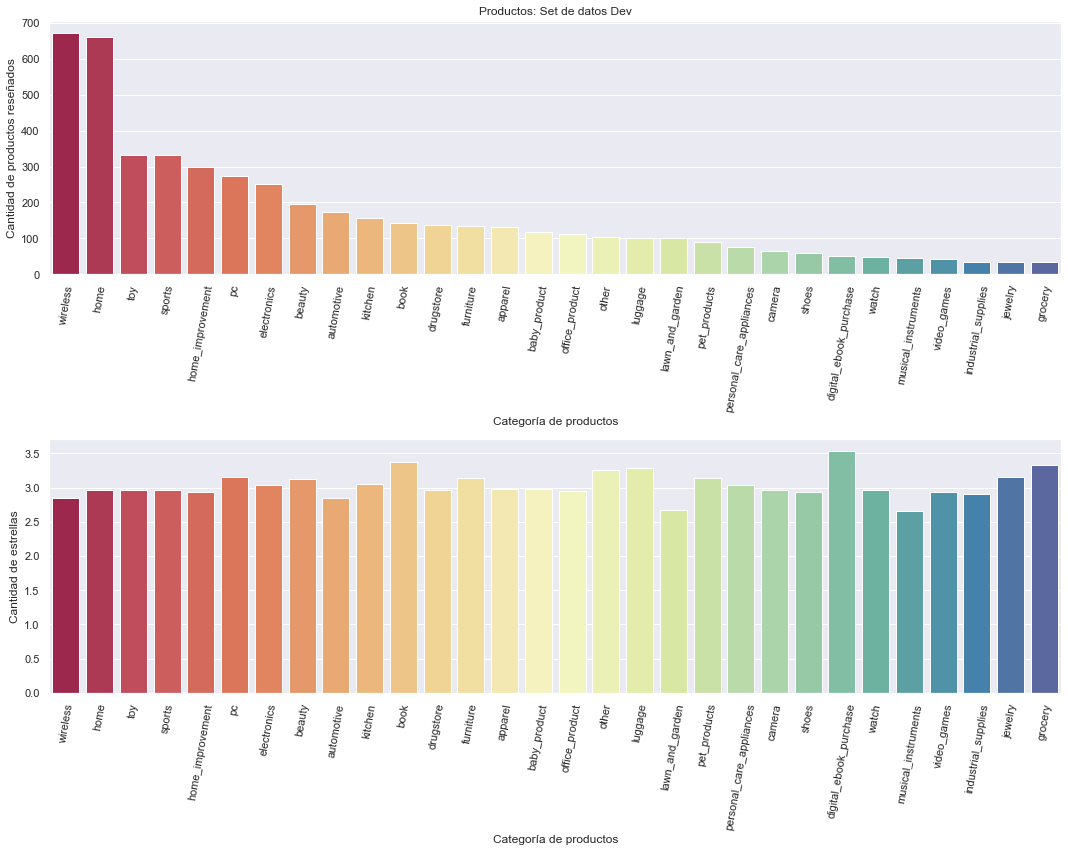

In [11]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
categoria_producto = dev['product_category'].value_counts();
promedio_estrellas = dev.groupby("product_category", as_index=False).mean()


sns.countplot(ax=axes[0], data=dev, x='product_category', palette="Spectral", order=categoria_producto.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Categoría de productos',ylabel='Cantidad de productos reseñados',title='Productos: Set de datos Dev')
sns.barplot(ax=axes[1], x = "product_category", y = "stars", data = promedio_estrellas, palette="Spectral", order=categoria_producto.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Categoría de productos',ylabel='Cantidad de estrellas')
plt.tight_layout();

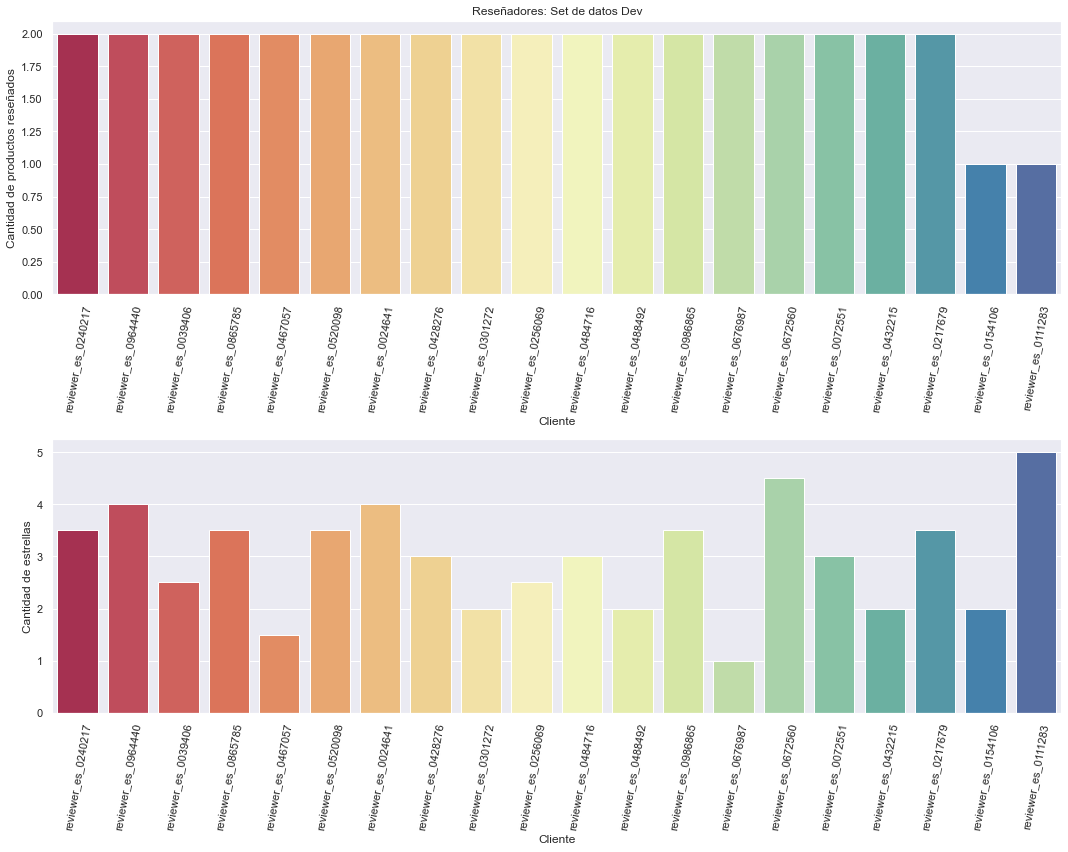

In [12]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
categoria_cliente = dev['reviewer_id'].value_counts()[:20];
promedio_estrellas = dev.loc[dev.reviewer_id.isin(categoria_cliente.index)].groupby("reviewer_id", as_index=False).mean()

sns.countplot(ax=axes[0], data=dev, x='reviewer_id', palette="Spectral", order=categoria_cliente.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Cliente',ylabel='Cantidad de productos reseñados',title='Reseñadores: Set de datos Dev')
sns.barplot(ax=axes[1], x = "reviewer_id", y = "stars", data = promedio_estrellas, palette="Spectral", order=categoria_cliente.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Cliente',ylabel='Cantidad de estrellas')
plt.tight_layout();

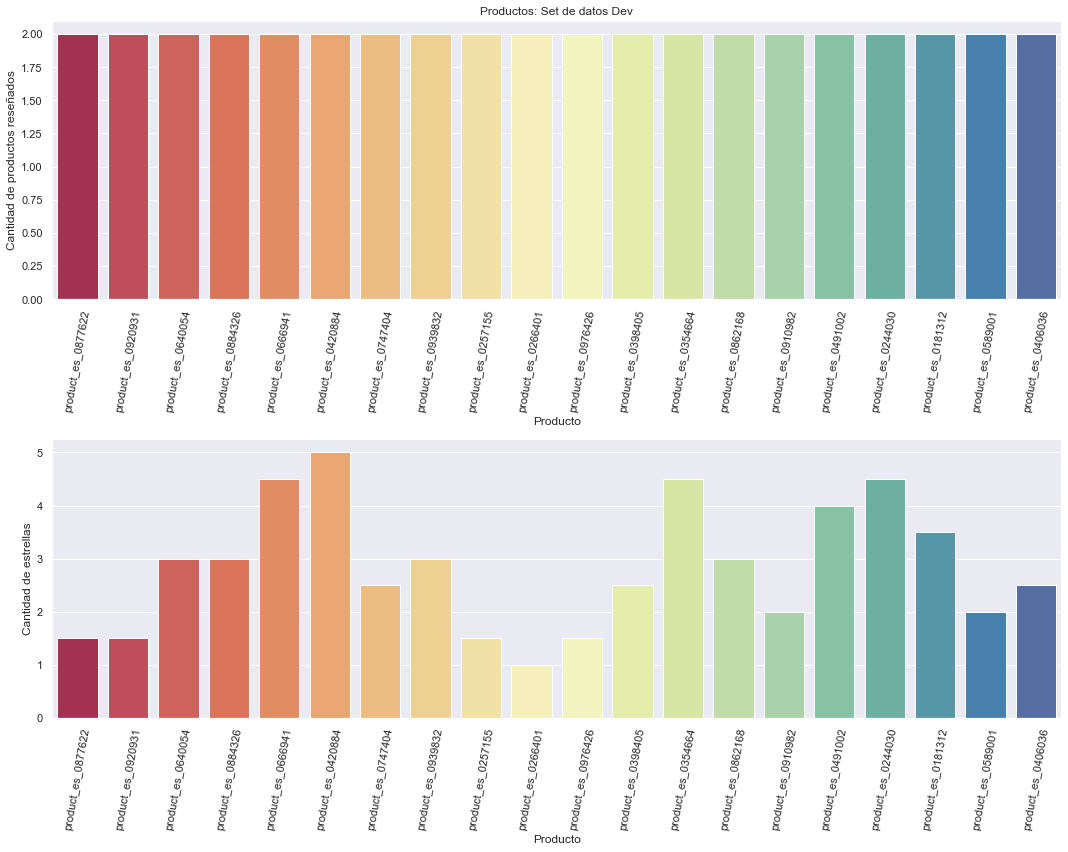

In [13]:
fig, axes = plt.subplots(2,1,figsize=(15, 12))
producto = dev['product_id'].value_counts()[:20];
promedio_estrellas = dev.loc[dev.product_id.isin(producto.index)].groupby("product_id", as_index=False).mean()

sns.countplot(ax=axes[0], data=dev, x='product_id', palette="Spectral", order=producto.index)
axes[0].tick_params(axis='x', labelrotation= 80)
axes[0].set(xlabel='Producto',ylabel='Cantidad de productos reseñados',title='Productos: Set de datos Dev')
sns.barplot(ax=axes[1], x = "product_id", y = "stars", data = promedio_estrellas, palette="Spectral", order=producto.index);
axes[1].tick_params(axis='x', labelrotation= 80)
axes[1].set(xlabel='Producto',ylabel='Cantidad de estrellas')
plt.tight_layout();

Como podemos ver, el tipo de producto no tiene un efecto muy fuerte en la puntuación promedio de este, la categoría mejor puntuada en promedio son los eBoooks, cuya calidad es estándar y su puntuacion depende de cuanto le guste al comprador el contenido. Y el reseñador o el producto tampoco son muy relevantes, ya que ambos tienen frecuencia máxima de 2 instancias: no hay reseñadores con alto volumen de reseñas ni positivas ni negativas que podrían afectar el modelo con maneras de escribir específicas a una sola persona, ni productos con muchos reviews que podrian afectar el modelo con palabras específicas a ese producto.

Verificamos la distribución  de estrellas en los set de datos:

In [14]:
dis_stars = pt.PrettyTable()
dis_stars.add_column('Estrellas', [1,2,3,4,5])
dis_stars.add_column('set Dev', dev.stars.value_counts().tolist())
dis_stars.add_column('set Train', train.stars.value_counts().tolist())
dis_stars.add_column('set Test', test.stars.value_counts().tolist())
print(dis_stars)

+-----------+---------+-----------+----------+
| Estrellas | set Dev | set Train | set Test |
+-----------+---------+-----------+----------+
|     1     |   1000  |   40000   |   1000   |
|     2     |   1000  |   40000   |   1000   |
|     3     |   1000  |   40000   |   1000   |
|     4     |   1000  |   40000   |   1000   |
|     5     |   1000  |   40000   |   1000   |
+-----------+---------+-----------+----------+


Las etiquetas están perfectamente distribuidas, indicando que las entradas del modelo van a estar balanceadas.

Finalmente, revisamos la cantidad de palabras que tienen los reviews:

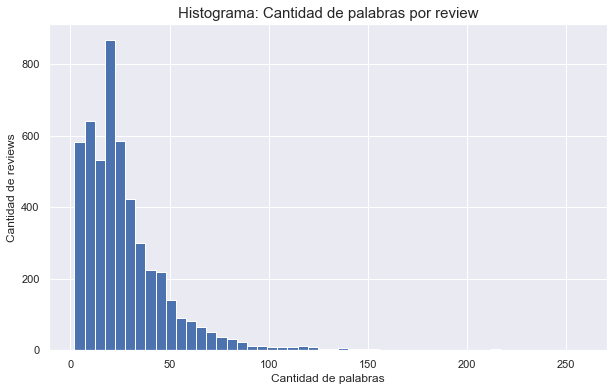

In [15]:
fig = plt.figure(figsize = (10,6))
ax = plt.axes()
words_per_review = dev.review_body.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 50)
ax.set(xlabel='Cantidad de palabras',ylabel='Cantidad de reviews')
plt.title('Histograma: Cantidad de palabras por review', fontsize=15);

In [16]:
print('La cantidad promedio de palabras por review es de:',words_per_review.mean())

La cantidad promedio de palabras por review es de: 27.572


# 2. Procesamiento de Lenguaje Natural

## 2.1. Pre-procesamiento de los datos

Con el fin de normalizar todos los datos para su evaluación se aplica la función *.lower* para que todos los carácteres estén en minúscula y evitar errores en los siguientes pasos.

In [6]:
for set in sets:
    set.review_body = set.review_body.apply(lambda x: x.lower())
    set.review_title = set.review_title.apply(lambda x: x.lower())

Adicionalmente, se eliminan las tildes, reemplazando las vocales tildadas por la vocal sin nada. Esto con el fin de unificar las palabras.

In [7]:
def tildes(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [8]:
for set in sets:
    set.review_body = set.review_body.apply(lambda x: tildes(x))
    set.review_title = set.review_title.apply(lambda x: tildes(x))

In [9]:
test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajeria horrible, no compro mas",amazon sigue sin cumplir en las entregas,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,estoy muy decepcionado con el vendedor ya que ...,estafa en el envio,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,mi valoracion no es sobre el producto sino sob...,estafa de amazon,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,pues tenia interes en este libro y probe la ve...,no consegui pasar de la portada en kindle,digital_ebook_purchase


Clasificamos los reviews como positivos para los que tienen 4 o 5 estrellas y negativos para los que tienen 3, 2 o 1 estrella.

In [9]:
for set in sets:
    set['binario'] = np.where(set.stars > 3, 1, 0)
    print(set['binario'].value_counts())

0    3000
1    2000
Name: binario, dtype: int64
0    3000
1    2000
Name: binario, dtype: int64
0    120000
1     80000
Name: binario, dtype: int64


## 2.2 Tokenización

Transformamos los reviews mediante un tokenizado para evaluar los comentarios por palabra. Adicionalmente eliminamos caracteres especiales,signos de puntuación, palabras mal escritas, números y emojis.

In [11]:
def limpieza2(dataset):

    characters_list = dataset.review_body.apply(lambda x: [each for each in x if not each.isalpha() and each != ' '])
    df_caracteres = []
    for i in range(len(characters_list)):
	    df_caracteres.append(characters_list[i])
    df_caracteres = [item for elem in df_caracteres for item in elem]

    sc = np.unique(df_caracteres)
    print(sc)
    dataset.review_body = dataset.review_body.apply(lambda x: ''.join([c for c in x if c not in sc]))
    print('Columna review_body')
    dataset.review_title = dataset.review_title.apply(lambda x: ''.join([c for c in x if c not in sc]))
    print('Columna review_title')
    
    return dataset.review_body, dataset.review_title

In [12]:
def tokenizar(df):

	new_df = df[['review_id','stars','binario','review_body','review_title']]

	new_df['body_token'] = new_df.review_body.apply(lambda x: nltk.tokenize.word_tokenize(x))
	new_df['title_token'] = new_df.review_title.apply(lambda x: nltk.tokenize.word_tokenize(x))
	print('Tokenizado')

	for column in ['body_token', 'title_token']:
		for i in range(len(new_df.body_token)):
			#new_df[column][i] = [word for word in new_df[column][i] if word not in characters]
			new_df[column][i] = [word for word in new_df[column][i] if word not in stopwords]
		print('Columna tokenizada')

	return new_df

In [13]:
dev.review_body, dev.review_title = limpieza2(dev)

['!' '"' '#' '%' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2' '3' '4'
 '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '_' '~' '¡' '°' '¿' '”' '…'
 '€' '❤' '️' '😂' '😊' '😌' '😒' '😔' '😡' '😣' '😤' '😬' '😳' '🙈' '🤔' '🤣']
Columna review_body
Columna review_title


In [31]:
dev

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,binario
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,malisimo muy grande demasiado aparatoso y mal ...,mala compra,es,wireless,0
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,no he recibido el pedido no la devolucion,no lo he recibido,es,apparel,0
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,es,sports,0
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,utilice las brocas de menor diametro y se me d...,brocas de mantequilla,es,home_improvement,0
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,no me gusta su olor a viejo y aspecto malo,no me gusta,es,beauty,0
...,...,...,...,...,...,...,...,...,...
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,me ha encantado la cesta ha llegado impecablet...,guadalupe,es,home,1
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,desempeña su funcion correctamente,calidad precio,es,camera,1
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,me ha encantado la diadema las flores son tal ...,excelente,es,toy,1
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,a mi me gustan mucho las fundas tpu ya que son...,genial,es,wireless,1


In [14]:
dev_token = tokenizar(dev)

Tokenizado
Columna tokenizada
Columna tokenizada


Como resultado observamos que las columnas tokenizadas estan conformadas por listas de las palabras representativas de los comentarios, en minúsculas y sin signos de puntuación:

In [17]:
dev_token.head()

,review_id,stars,binario,review_body,review_title,body_token,title_token
0,es_0417480,1,0,malisimo muy grande demasiado aparatoso y mal ...,mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]"
1,es_0180432,1,0,no he recibido el pedido no la devolucion,no lo he recibido,"[no, recibido, pedido, no, devolucion]","[no, recibido]"
2,es_0144850,1,0,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,"[buscar, sistema, no, funciona, bien, abrazade...","[no, aprieta, bien, manillar]"
3,es_0339629,1,0,utilice las brocas de menor diametro y se me d...,brocas de mantequilla,"[utilice, brocas, menor, diametro, doblaron, v...","[brocas, mantequilla]"
4,es_0858362,1,0,no me gusta su olor a viejo y aspecto malo,no me gusta,"[no, gusta, olor, viejo, aspecto, malo]","[no, gusta]"


## 2.3 Lemmatización

Evaluamos la librería Spacy para realizar la lemmatización:

In [15]:
import spacy
#spacy.prefer_gpu()
nlp = spacy.load("es_core_news_sm")

In [16]:
Lemma_prueba = pd.DataFrame(columns = ['Token','Token Text','Token Pos', 'Token Lemma'])
dev_token['body_lemma'] = dev_token.body_token.apply(lambda x: ' '.join(x))
doc = nlp(dev_token['body_lemma'][2])
for token in doc:
    Lemma_prueba = Lemma_prueba.append({'Token':token, 'Token Text':token.text, 'Token Pos':token.pos_,
    'Token Lemma':token.lemma_}, ignore_index=True)
print(Lemma_prueba)

         Token  Token Text Token Pos Token Lemma
0       buscar      buscar      VERB      buscar
1      sistema     sistema      NOUN     sistema
2           no          no       ADV          no
3     funciona    funciona      VERB   funcionar
4         bien        bien       ADV        bien
5   abrazadera  abrazadera      NOUN  abrazadera
6        lleva       lleva      VERB      llevar
7      agarrar     agarrar      VERB     agarrar
8     manillar    manillar      VERB    manillar
9           no          no       ADV          no
10     aprieta     aprieta      VERB     apretar
11        bien        bien       ADV        bien
12  deslizando  deslizando      VERB    deslizar
13    linterna    linterna      VERB    linterna
14       hacia       hacia       ADP       hacia
15       abajo       abajo       ADV      abajar


In [17]:
dev_token['body_lemma'] = dev_token.body_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])
dev_token['title_lemma'] = dev_token.title_token.apply(lambda x: ' '.join(x))
dev_token['title_lemma'] = dev_token.title_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])

In [18]:
dev_token.head()

,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma
0,es_0417480,1,0,malisimo muy grande demasiado aparatoso y mal ...,mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]","[malisimo, grande, demasiar, aparatoso, mal, p...","[malo, comprar]"
1,es_0180432,1,0,no he recibido el pedido no la devolucion,no lo he recibido,"[no, recibido, pedido, no, devolucion]","[no, recibido]","[no, recibir, pedir, no, devolucion]","[no, recibir]"
2,es_0144850,1,0,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,"[buscar, sistema, no, funciona, bien, abrazade...","[no, aprieta, bien, manillar]","[buscar, sistema, no, funcionar, bien, abrazad...","[no, apretar, bien, manillar]"
3,es_0339629,1,0,utilice las brocas de menor diametro y se me d...,brocas de mantequilla,"[utilice, brocas, menor, diametro, doblaron, v...","[brocas, mantequilla]","[utilizar, broca, menor, diametro, doblar, var...","[broca, mantequilla]"
4,es_0858362,1,0,no me gusta su olor a viejo y aspecto malo,no me gusta,"[no, gusta, olor, viejo, aspecto, malo]","[no, gusta]","[no, gustar, olor, viejo, aspecto, malo]","[no, gustar]"


## 2.4 Análisis de Frecuencia de las palabras

De acuerdo con el procesamiento anterior obtenemos una primera versión de la frecuencia de palabras que en general determinan si un comentario es positivo o negativo respecto a la clasficación propuesta. Para analizar desarrollamos las gráficas de frecuencia:

In [19]:
#Función de frecuencias de las palabras
def get_freqs(df,columna,titulo):

	# Guardamos todos los titulos y reseñas buenos y malos en listas separadas
	df_malos = df.loc[df.stars.isin([1,2,3])]
	df_buenos = df.loc[df.stars.isin([4,5])]
	df_malos.reset_index(inplace= True)
	df_buenos.reset_index(inplace= True)

	# Guardamos todos los titulos y reseñas buenos y malos en listas separadas
	df_malos_lista = []
	for i in range(len(df_malos.review_title)):
		df_malos_lista.append(df_malos[columna][i])
	df_malos_lista = [item for elem in df_malos_lista for item in elem]

	df_buenos_lista = []
	for i in range(len(df_buenos.review_title)):
		df_buenos_lista.append(df_buenos[columna][i])
	df_buenos_lista = [item for elem in df_buenos_lista for item in elem]

	# Hacemos 4 dataframes con las frecuencias de las palabras
	df_malos_lista_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_malos_lista), orient = 'index')
	df_malos_lista_freq['word'] = df_malos_lista_freq.index
	df_malos_lista_freq.sort_values(by = 0, ascending= False, inplace = True)

	df_buenos_lista_freq = pd.DataFrame.from_dict(nltk.FreqDist(df_buenos_lista), orient = 'index')
	df_buenos_lista_freq['word'] = df_buenos_lista_freq.index
	df_buenos_lista_freq.sort_values(by = 0, ascending= False, inplace = True)

	#Gráfica
	plt.figure(figsize= (8,4))
	plt.subplot(121)
	sns.barplot(x = df_malos_lista_freq[0][:10], y = df_malos_lista_freq.word[:10])
	plt.title(titulo + ': negativo')
	plt.xlabel('Cantidad')
	plt.subplot(122)
	sns.barplot(x = df_buenos_lista_freq[0][:10], y = df_buenos_lista_freq.word[:10])
	plt.title(titulo + ': positivo')
	plt.xlabel('Cantidad')
	plt.tight_layout();
	plt.show()

	return

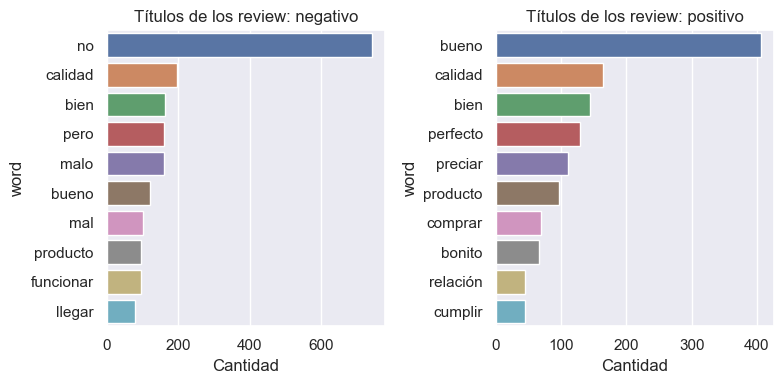

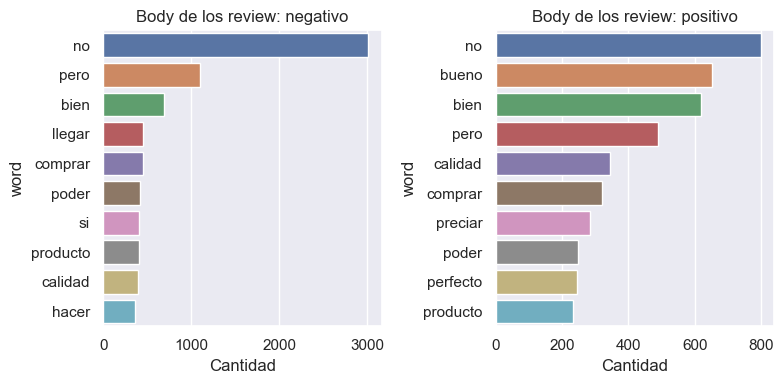

In [20]:
get_freqs(dev_token,'title_lemma','Títulos de los review')
get_freqs(dev_token,'body_lemma','Body de los review')

Las gráficas demuestran que hay muchas palabras que son muy comunes en todos los reviews y que se repiten tanto en los comentarios positivos como en los negativos como por ejemplo *calidad*, *producto* y *bien*. Por tanto, se decide eliminar algunas de las palabras más repetidas en todos los comentarios para evaluar unicamente las palabras representativas que permitan realizar la clasificación.

In [20]:
all_lemmas = []
for i in range(len(dev_token.body_lemma)):
	all_lemmas.append(dev_token.body_lemma[i])
all_lemmas = [item for elem in all_lemmas for item in elem]

one_percentile = int(len(np.unique(all_lemmas)) * 0.01)

#1% de las palabras más comunes del dataset
from collections import Counter
count_freq = Counter(all_lemmas).most_common(one_percentile)
count_notfreq = Counter(all_lemmas).most_common()[-one_percentile:]

Del vector de palabras frecuentes se eliminan algunas que después de algunas pruebas se consideran fundamentales en le predicción.

In [21]:
a_remover = [word for word,val in count_freq] + [word for word,val in count_notfreq]
no_remover = ['bien', 'bueno','perfecto','malo','problema','tiempo','mal','encantar','perfectamente','no','mejor']
for i in no_remover:
    if i in a_remover:
        a_remover.remove(i)

In [22]:
#Código para remover las palabras
dev_token['title_lemma_rm'] = dev_token.title_lemma.apply(lambda x: [word for word in x if word not in a_remover])
dev_token['body_lemma_rm'] = dev_token.body_lemma.apply(lambda x: [word for word in x if word not in a_remover])

De forma que las nuevas gráficas resultante son las siguientes:

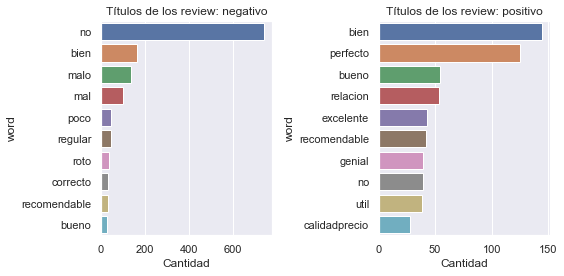

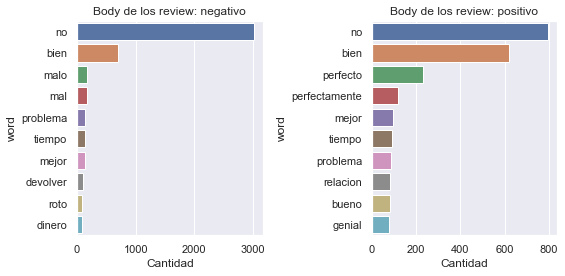

In [38]:
get_freqs(dev_token,'title_lemma_rm','Títulos de los review')
get_freqs(dev_token,'body_lemma_rm','Body de los review')

Verificamos que se eliminan las palabras más comunes que no aportaban información valiosa a la clasificación y nos quedamos con palabras más significativas como: *recomendable* o *útil* para comentarios positivos, y *defectuoso* o *devolver* para comentarios negativos. 

Sumaremos las palabras del titulo a las del cuerpo para tenerlas todas en un mismo feature. 

In [23]:
dev_token['words'] = dev_token['title_lemma'] + dev_token['body_lemma']
dev_token['words_rm'] = dev_token['title_lemma_rm'] + dev_token['body_lemma_rm']
dev_token.head()

,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma,title_lemma_rm,body_lemma_rm,words,words_rm
0,es_0417480,1,0,malisimo muy grande demasiado aparatoso y mal ...,mala compra,"[malisimo, grande, demasiado, aparatoso, mal, ...","[mala, compra]","[malisimo, grande, demasiar, aparatoso, mal, p...","[malo, comprar]",[malo],"[malisimo, aparatoso, mal, protector]","[malo, comprar, malisimo, grande, demasiar, ap...","[malo, malisimo, aparatoso, mal, protector]"
1,es_0180432,1,0,no he recibido el pedido no la devolucion,no lo he recibido,"[no, recibido, pedido, no, devolucion]","[no, recibido]","[no, recibir, pedir, no, devolucion]","[no, recibir]","[no, recibir]","[no, recibir, no, devolucion]","[no, recibir, no, recibir, pedir, no, devolucion]","[no, recibir, no, recibir, no, devolucion]"
2,es_0144850,1,0,tengo que buscar otro sistema este no funciona...,que no aprieta bien en el manillar,"[buscar, sistema, no, funciona, bien, abrazade...","[no, aprieta, bien, manillar]","[buscar, sistema, no, funcionar, bien, abrazad...","[no, apretar, bien, manillar]","[no, apretar, bien, manillar]","[buscar, sistema, no, bien, abrazadera, agarra...","[no, apretar, bien, manillar, buscar, sistema,...","[no, apretar, bien, manillar, buscar, sistema,..."
3,es_0339629,1,0,utilice las brocas de menor diametro y se me d...,brocas de mantequilla,"[utilice, brocas, menor, diametro, doblaron, v...","[brocas, mantequilla]","[utilizar, broca, menor, diametro, doblar, var...","[broca, mantequilla]","[broca, mantequilla]","[utilizar, broca, menor, diametro, doblar, var...","[broca, mantequilla, utilizar, broca, menor, d...","[broca, mantequilla, utilizar, broca, menor, d..."
4,es_0858362,1,0,no me gusta su olor a viejo y aspecto malo,no me gusta,"[no, gusta, olor, viejo, aspecto, malo]","[no, gusta]","[no, gustar, olor, viejo, aspecto, malo]","[no, gustar]",[no],"[no, olor, viejo, aspecto, malo]","[no, gustar, no, gustar, olor, viejo, aspecto,...","[no, no, olor, viejo, aspecto, malo]"


Con el dataset tokenizado, utilizaremos el título y cuerpo de los reviews para realizar modelos que los clasifiquen inicialmente de manera binaria, de forma que sea más sencillo identificar errores y mejoras en la sección de pre-procesamiento y obtener el mejor modelo posible por clasificación binaria como benchmark. Posteriormente continuaremos con los modelos de clasificación para las 5 estrellas. 

Para lo anterior definimos las palabras como vectores usando la estrategia Bag of Words que guarda para cada entrada un vector donde todas las palabras del corpus son una variable y el numero que la funcion le asigna es las veces que aparece en la reseña particular.

Transformamos el dataset asi:

In [24]:
#dev_token = pd.read_csv('dataset_dev_token.csv')
data = dev_token[['words','words_rm','stars','binario']]
data['words_joint'] = data.words.apply(lambda x: ' '.join(x))
data['words_joint_rm'] = data.words_rm.apply(lambda x: ' '.join(x))

In [25]:
data.head()

,words,words_rm,stars,binario,words_joint,words_joint_rm
0,"[malo, comprar, malisimo, grande, demasiar, ap...","[malo, malisimo, aparatoso, mal, protector]",1,0,malo comprar malisimo grande demasiar aparatos...,malo malisimo aparatoso mal protector
1,"[no, recibir, no, recibir, pedir, no, devolucion]","[no, recibir, no, recibir, no, devolucion]",1,0,no recibir no recibir pedir no devolucion,no recibir no recibir no devolucion
2,"[no, apretar, bien, manillar, buscar, sistema,...","[no, apretar, bien, manillar, buscar, sistema,...",1,0,no apretar bien manillar buscar sistema no fun...,no apretar bien manillar buscar sistema no bie...
3,"[broca, mantequilla, utilizar, broca, menor, d...","[broca, mantequilla, utilizar, broca, menor, d...",1,0,broca mantequilla utilizar broca menor diametr...,broca mantequilla utilizar broca menor diametr...
4,"[no, gustar, no, gustar, olor, viejo, aspecto,...","[no, no, olor, viejo, aspecto, malo]",1,0,no gustar no gustar olor viejo aspecto malo,no no olor viejo aspecto malo


# 3. Métricas de Evaluación


Definimos las métricas de *accuracy, f1_score y matriz de confusión* para evaluar los modelos.

In [26]:
def error(nombre, modelo, X_train, y_train, X_test, y_test, y_pred):
    
    # Data Frame para guardar los resultados
    errores = pd.DataFrame(columns = ['Modelo','Accuracy','f1_score', 'VP', 'VN','FP', 'FN'])

    accuracy = accuracy_score(y_test, y_pred)
    f1_sco = f1_score(y_test, y_pred, average='binary')

    names= ["Positivo", "Negativo"]
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(4,4))
    sns.heatmap(cm,annot=True, fmt=".0f",ax=ax, cmap='Blues')
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    vn, fp, fn, vp = confusion_matrix(y_test, y_pred).ravel()
    errores = errores.append({'Modelo':nombre,'Accuracy':accuracy,'f1_score':f1_sco, 'VP':vp, 'VN':vn,'FP':fp, 'FN':fn},  ignore_index=True)

    return errores

In [27]:
def errores_reviews(y_test, y_pred, dev_token, columna):
    errores_pos = []
    errores_neg = []
    errores_total = []
    for i in range(1500):
        #print(y_test.iloc[i], y_pred[i])
        if y_test.iloc[i] != y_pred[i]:
            if y_test.iloc[i] == 0:
                errores_neg.append(y_test.index[i])
                errores_total.append(y_test.index[i])
            else:
                errores_pos.append(y_test.index[i])
                errores_total.append(y_test.index[i])
    datos_pos = dev_token.loc[dev_token.index.isin(errores_pos),['review_title','review_body',columna]]
    datos_neg = dev_token.loc[dev_token.index.isin(errores_neg),['review_title','review_body',columna]] 
    print('Errores por cantidad de estrellas:')
    print(dev_token.loc[errores_total].groupby('stars').words.count())
    return datos_pos, datos_neg

In [28]:
def error5(nombre, modelo, X_train, y_train, X_test, y_test, y_pred, dev_token):
    
    # Data Frame para guardar los resultados
    errores5 = pd.DataFrame(columns = ['Modelo','Accuracy','Errores 1','Errores 2','Errores 3','Errores 4','Errores 5'])
    accuracy = modelo.score(X_test,y_test)

    #names= y_train.unique().tolist()
    names= ["1","2","3","4","5"]
    cm=confusion_matrix(y_test,y_pred)
    f,ax=plt.subplots(figsize=(3,3))
    sns.heatmap(cm,annot=True,fmt=".0f",ax=ax, cmap='Blues')
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    errores_total = []
    for i in range(len(y_test)):
        #print(y_test.iloc[i], y_pred[i])
        if y_test.iloc[i] != y_pred[i]:
            errores_total.append(y_test.index[i])

    e_stars = dev_token.loc[errores_total].groupby('stars').words.count()

    errores5 = errores5.append({'Modelo':nombre,'Accuracy':accuracy,'Errores 1':e_stars.iloc[0],'Errores 2':e_stars.iloc[1],
    'Errores 3':e_stars.iloc[2],'Errores 4':e_stars.iloc[3],'Errores 5':e_stars.iloc[4]},  ignore_index=True)

    return errores5

# 4. Modelos de Machine Learning Binarios 

Ahora, a partir de los resultados procesados y organizados, procedemos a aplicar los modelos de Machine Learning para obtener la clasificación y número de estrellas por comentario.

Iniciaremos estableciendo como Benchmark el modelo que mejor clasifique los reviews de manera binaria: buenos o malos. Para esto evaluaremos un random forest y una regresión logística, utilizando el dataset tokenizado y la columna binario previamente establecida en la que 4 y 5 estrellas hacen un buen review y 1, 2 o 3 hacen uno malo.

## 4.1 Dataset Tokenizado

In [31]:
vectorizador=CountVectorizer(lowercase = False)

# Para los datos sin remover palabras
data_vec = vectorizador.fit_transform(data.words_joint)
X_data = data_vec.toarray()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_data, data['binario'], test_size = 0.3, random_state=42)

### 4.1.1 Random Forest Classifier

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


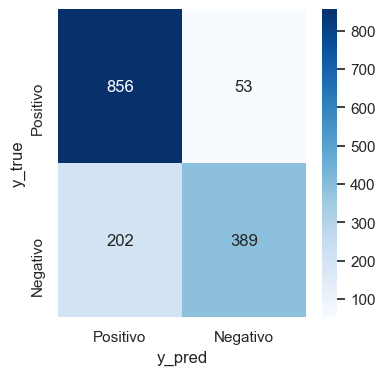

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.83,0.753146,389,856,53,202


In [33]:
#params = {'n_estimators': [50,100,150,200], 'max_depth': [10,15,30,45]}
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)

errores = error('Random Forest Tokenizado', best_rf, X_train, y_train, X_test, y_test, y_pred)
errores

**Evaluación de los reviews mal predichos:**

In [34]:
datos_pos, datos_neg = errores_reviews(y_test, y_pred, dev_token, 'words_rm')

Errores por cantidad de estrellas:
stars
1      1
2      7
3     45
4    127
5     75
Name: words, dtype: int64


In [35]:
print('Reviews positivos calificados como negativos:')
datos_pos.head()

Reviews positivos calificados como negativos:


,review_title,review_body,words_rm
3006,bastante completo,no me gusta las instrucciones en ingles,"[completar, no, instrucción, ingle]"
3007,cobran mucho por el envio,llego bien pero el ultimo dia tardo casi una s...,"[cobrar, envio, bien, ultimar, tardar, casi, s..."
3017,su ligereza,que es muy ligero aunque un poco bajo y el ple...,"[ligereza, ligero, bajar, plegar, complicar, n..."
3024,ocupa poco y la ranura es amplia,la tengo hace menos de un mes y me gusta pero ...,"[ocupar, ranurar, amplio, mes, creer, caro, re..."
3027,el frigorifico es perfecto el color silver no ...,el frigorifico es perfecto el color silver no ...,"[frigorifico, perfecto, color, silver, no, rea..."


In [36]:
print('Reviews negativos calificados como positivos:')
datos_neg.head()

Reviews negativos calificados como positivos:


,review_title,review_body,words_rm
259,entrega tarde,producto perfecto entrega con seur nefastalleg...,"[entregar, tardar, perfecto, entregar, seur, n..."
1023,un poco disgustada,estaba muy ilusionada porque a mi marido siemp...,"[disgustar, ilusionar, maridar, siempre, zippo..."
1420,bien,es muy mono relacion calidad precio buena aunq...,"[bien, mono, relacion, bueno, no, maravilloso]"
1598,calidadprecio perfecto pero ha llegado dañado,el album genial en relacion calidadprecio pero...,"[calidadprecio, perfecto, dañar, album, genial..."
1610,el segundo que compro y desilusion,hace mas de un año compre uno y estaba encanta...,"[segundar, desilusion, año, encantar, problema..."


A partir de este primer modelo y la revisión de los errores, identificamos las palabras a eliminar y mantener de la sección 2.4. Por ejemplo, obtuvimos mejores resultados manteniendo la palabra 'no' que quitándola, manteniendo palabras como 'perfecto', 'mal y 'bueno' y eliminando palabras como 'pero'.

La mayor cantidad de errores de predicción se da en los reviews con 4 estrellas, ya que aunque los comentarios son buenos incluyen palabras de queja respecto a algún detalle que molestó al cliente, y estas palabras son consideradas por el modelo como elementos negativos que clasifican en general el review como negativo.

### 4.1.2 Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.09)


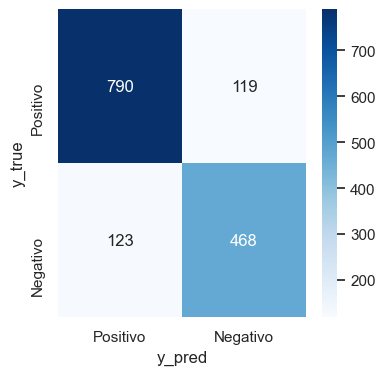

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123


In [37]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0.01, 0.095, 0.09,0.08,0.07,0.06]}
params = {'penalty': ['l1'],'tol': [0.09]}

lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)

print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)

errores = errores.append(error('Regresión Logística Tokenizado', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

In [38]:
datos_pos, datos_neg = errores_reviews(y_test, y_pred, dev_token, 'words_rm')

Errores por cantidad de estrellas:
stars
1    14
2    23
3    82
4    81
5    42
Name: words, dtype: int64


Miramos para estos dos predictores, los reviews que fueron difíciles de predecir para ambos. Desde ya vemos que 3 y 4 estrellas fueron los peor predichos en sus grupos respectivos para ambos modelos, pero que la mayoria de errores está en la categoria de buenos reviews. Exploramos más a continuación:

In [39]:
print('Reviews positivos calificados como negativos:')
datos_pos.head()

Reviews positivos calificados como negativos:


,review_title,review_body,words_rm
3007,cobran mucho por el envio,llego bien pero el ultimo dia tardo casi una s...,"[cobrar, envio, bien, ultimar, tardar, casi, s..."
3017,su ligereza,que es muy ligero aunque un poco bajo y el ple...,"[ligereza, ligero, bajar, plegar, complicar, n..."
3024,ocupa poco y la ranura es amplia,la tengo hace menos de un mes y me gusta pero ...,"[ocupar, ranurar, amplio, mes, creer, caro, re..."
3036,muy bonito pero tiene solo una hebilla,pone en la descripcion que es de doble hebilla...,"[hebilla, descripcion, doblar, hebilla, solame..."
3043,divertido,juego muy entretenido y educativo para toda fa...,"[divertir, jugar, entretener, educativo, todo,..."


In [40]:
print('Reviews negativos calificados como positivos:')
datos_neg.head()

Reviews negativos calificados como positivos:


,review_title,review_body,words_rm
191,libro abandonado,no he podido leerlo no es mi estilo,"[librar, abandonar, no, leerlo, no, estilar]"
214,me gusta pero hay otras mas baratas de la mism...,cambio mi opinion es incomoda cuando llevas un...,"[barato, cambiar, opinion, incomodar, rato, se..."
254,se levanta,de las unidades ya he gastado porque se leva...,"[levantar, unidad, gastar, levantar, seguir, i..."
259,entrega tarde,producto perfecto entrega con seur nefastalleg...,"[entregar, tardar, perfecto, entregar, seur, n..."
330,complicado de imprimir,es complicado de imprimir recomiendo para los ...,"[complicar, imprimir, complicar, imprimir, pri..."


Observamos que estos reviews empiezan hablando de positivos antes de luego decir lo que no les gustó del producto. Si la parte positiva del review tiene mayor extensión que la negativa, será muy dificil que el modelo lo clasifique bien. 

### 4.1.3 Complement Naive Bayes

El modelo multinomial Naive Bayes trabaja sobre datasets con varios labels, y es uno de los tipos de modelo basado en el teorema de Bayes que se usan clasicamente en problemas de clasificación de texto con vectorizaciones del tipo Bag of Words. Una modificación de este que ha probado tener mejores resultados consistentemente es el modelo Complement Naive Bayes, optimizado para datasets desbalanceados.

Como este último no es nuestro caso, no podemos elegir uno de estos dos modelos sin probarlos ambos, lo hacemos a continuación: 

ComplementNB(alpha=1.7)


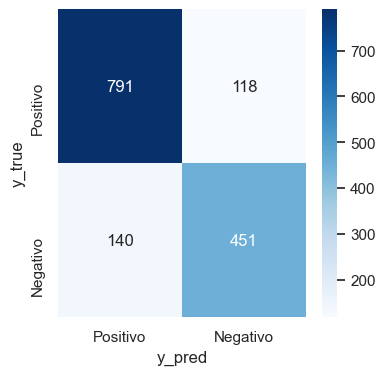

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140


In [41]:
#params = {'alpha': [1.4, 1.5, 1.6, 1.7, 1.8, 1.9], 'norm': [True, False]}
params = {'alpha': [1.7], 'norm': [True, False]}
cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Tokenizado', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

## 4.2 Dataset tokenizado con palabras removidas

In [42]:
vectorizador=CountVectorizer(lowercase = False)

# Para los datos con palabras removidas
data_vec = vectorizador.fit_transform(data.words_joint_rm)
X_data_rm = data_vec.toarray()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_data_rm, data['binario'], test_size = 0.3, random_state=42)

### 4.2.1 Random Forest Classifier

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


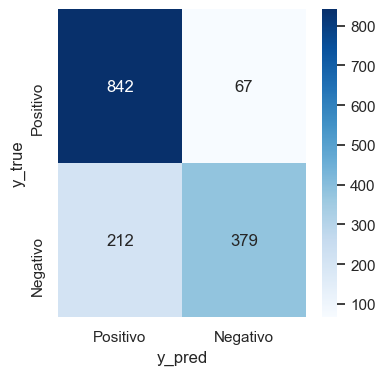

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212


In [44]:
#params = {'n_estimators': [50,,100,150,200], 'max_depth': [10,,15,30,45]}
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)

errores = errores.append(error('Random Forest Removidas', best_rf, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.2.2 Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.09)


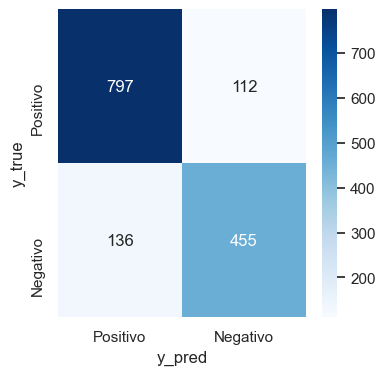

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136


In [45]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0.06,0.07,0.08,0.09,0.095,0.01]}
params = {'penalty': ['l1'],'tol': [0.09]}

lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)

errores = errores.append(error('Regresión Logística Removidas', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.2.3 Naive Bayes Complement NB

ComplementNB(alpha=2.3)


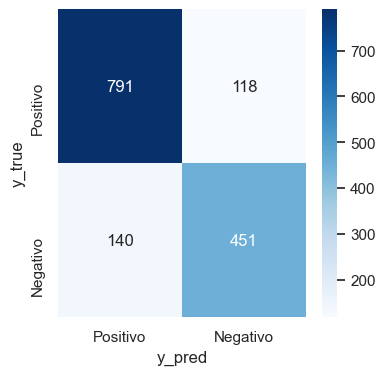

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136
0,Naive Bayes ComplementNB Removidas,0.828000,0.777586,451,791,118,140


In [46]:
#params = {'alpha': [2.1, 2.2, 2.3, 2.4, 2.5], 'norm': [True, False]}
params = {'alpha': [2.3], 'norm': [True, False]}
		  
cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Removidas', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

## 4.3 Bigramas

Sabemos que el mejor modelo para tokens únicos es un Logistic Regressor con Accuracy de alrededor del 81%, intentaremos mejorar sobre este benchmark usando estos mismos modelos con bigramas en vez de unigramas.

In [47]:
# Generamos el dataset con los bigramas
new_vec = CountVectorizer(analyzer='word', ngram_range=(2, 2))
new_data_vec = new_vec.fit_transform(data.words_joint)
X_data_bi = new_data_vec.toarray()

# Tomamos los bigramas unicos
all_bigrams = new_vec.get_feature_names()
print(len(all_bigrams))

53407


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_data_bi, data['binario'], test_size = 0.3, random_state=42)

### 4.3.1 Random Forest

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


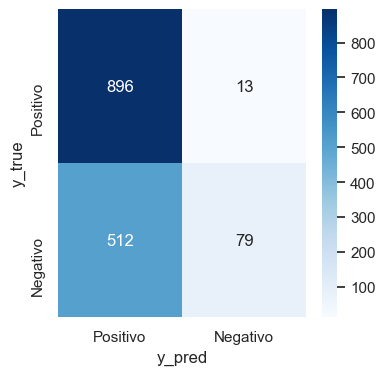

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136
0,Naive Bayes ComplementNB Removidas,0.828000,0.777586,451,791,118,140
0,Random Forest Bigrama,0.650000,0.231332,79,896,13,512


In [49]:
# Utilizamos el mejor estimador Random Forest, con esta nueva data
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)

errores = errores.append(error('Random Forest Bigrama', best_rf, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.3.2. Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.01)


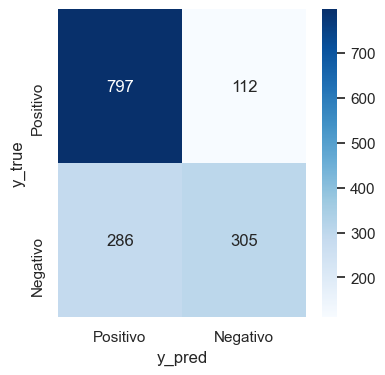

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136
0,Naive Bayes ComplementNB Removidas,0.828000,0.777586,451,791,118,140
0,Random Forest Bigrama,0.650000,0.231332,79,896,13,512
0,Regresión Logística Bigrama,0.734667,0.605159,305,797,112,286


In [50]:
params = {'penalty': ['l1'],'tol': [0.01]}
lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)

errores = errores.append(error('Regresión Logística Bigrama', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.3.3 Complement Naive Bayes Complement

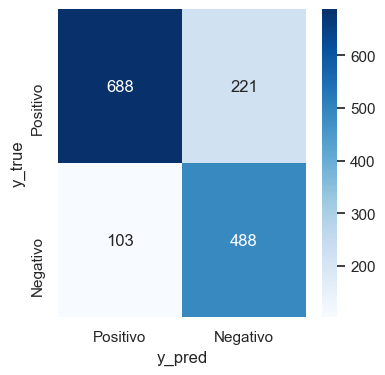

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136
0,Naive Bayes ComplementNB Removidas,0.828000,0.777586,451,791,118,140
0,Random Forest Bigrama,0.650000,0.231332,79,896,13,512
0,Regresión Logística Bigrama,0.734667,0.605159,305,797,112,286
0,Naive Bayes ComplementNB Bigrama,0.784000,0.750769,488,688,221,103


In [51]:
#params = {'alpha': [2.8, 2, 2.1, 2.2, 2.3, 2.4, 2.5], 'norm': [True, False]}
params = {'alpha': [2.8], 'norm': [True, False]}	  
cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Bigrama', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

## 4.4 Dataset con bigrama afirmativo y negativo

Con base en los resultados anteriores, consideramos como mejora al dataset: mantener los datos lemmatizados sin remover las palabras más frecuentes, pero unir las palabras 'no' con la siguiente palabra tokenizada, de forma que obtengamos palabras como; 'nollegar', 'nofuncionar', 'nogustar'.

In [52]:
data['words_no'] = data['words_joint'].apply(lambda x: re.sub('^no\s',' no',x))
data['words_no'] = data['words_no'].apply(lambda x: re.sub('\sno\s',' no',x))
data['words_no'] = data['words_no'].apply(lambda x: re.sub('^si\s',' si',x))
data['words_no'] = data['words_no'].apply(lambda x: re.sub('\ssi\s',' si',x))

In [53]:
vectorizador=CountVectorizer(lowercase = False)
# Para los datos sin remover palabras
data_vec_no = vectorizador.fit_transform(data.words_no)
X_data_no = data_vec_no.toarray()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_data_no, data['binario'], test_size = 0.3, random_state=42)

### 4.4.1 Random Forest

RandomForestClassifier(max_depth=45, n_estimators=200, random_state=42)


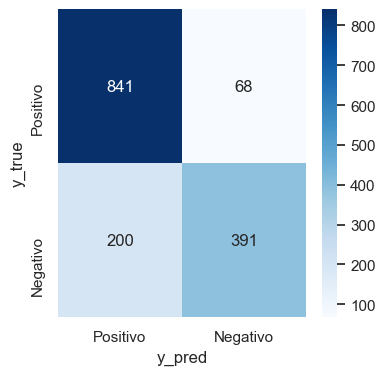

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136
0,Naive Bayes ComplementNB Removidas,0.828000,0.777586,451,791,118,140
0,Random Forest Bigrama,0.650000,0.231332,79,896,13,512
0,Regresión Logística Bigrama,0.734667,0.605159,305,797,112,286
0,Naive Bayes ComplementNB Bigrama,0.784000,0.750769,488,688,221,103
0,Random Forest Bigrama Si/No,0.821333,0.744762,391,841,68,200


In [55]:
#params = {'n_estimators': [50,,100,150,200], 'max_depth': [10,,15,30,45]}
params = {'n_estimators': [200],'max_depth': [45]}
rf = RandomForestClassifier(random_state=42)
rfo = GridSearchCV(rf, params)
rfo.fit(X_train,y_train)
print(rfo.best_estimator_)
best_rf = rfo.best_estimator_
y_pred = rfo.predict(X_test)
errores = errores.append(error('Random Forest Bigrama Si/No', best_rf, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.4.2 Regresión Logística

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.07)


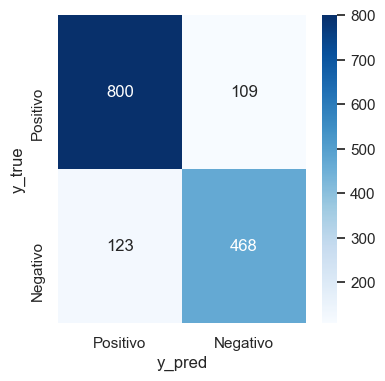

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136
0,Naive Bayes ComplementNB Removidas,0.828000,0.777586,451,791,118,140
0,Random Forest Bigrama,0.650000,0.231332,79,896,13,512
0,Regresión Logística Bigrama,0.734667,0.605159,305,797,112,286
0,Naive Bayes ComplementNB Bigrama,0.784000,0.750769,488,688,221,103
0,Random Forest Bigrama Si/No,0.821333,0.744762,391,841,68,200


In [56]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0.08, 0.07, 0.0,6, 0.05, 0.04, 0.03, 0.02]}
params = {'penalty': ['l1'],'tol': [0.07]}
lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train, y_train)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test)
errores = errores.append(error('Regresión Logística Bigrama Si/No', best_lr, X_train, y_train, X_test, y_test, y_pred))
errores

### 4.3.3 Naive Bayes Complement NB

ComplementNB(alpha=1.7)


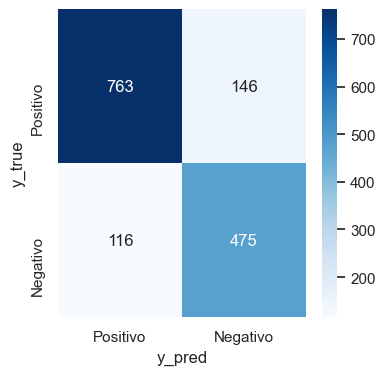

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Random Forest Tokenizado,0.830000,0.753146,389,856,53,202
0,Regresión Logística Tokenizado,0.838667,0.794567,468,790,119,123
0,Naive Bayes ComplementNB Tokenizado,0.828000,0.777586,451,791,118,140
0,Random Forest Removidas,0.814000,0.730955,379,842,67,212
0,Regresión Logística Removidas,0.834667,0.785838,455,797,112,136
0,Naive Bayes ComplementNB Removidas,0.828000,0.777586,451,791,118,140
0,Random Forest Bigrama,0.650000,0.231332,79,896,13,512
0,Regresión Logística Bigrama,0.734667,0.605159,305,797,112,286
0,Naive Bayes ComplementNB Bigrama,0.784000,0.750769,488,688,221,103
0,Random Forest Bigrama Si/No,0.821333,0.744762,391,841,68,200


In [57]:
#params = {'alpha': [1.3, 1.4, 1.5, 1.6, 1.7, 1.8],'norm': [True, False]}
params = {'alpha': [1.7],'norm': [True, False]}

cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)

errores = errores.append(error('Naive Bayes ComplementNB Bigrama Si/No', cnb_model, X_train, y_train, X_test, y_test, y_pred))
errores

A partir de todos los resultados, datasets y modelos, se aplicaron diferentes técnicas para conseguir mejorar las métricas de los modelos, desde el tokenizado, la organización de las palabras, la lemmatización y los parámetros; de forma que logramos pasar de accuracy de alrededor de 0.65 hasta el mayor accuracy conseguido de 0.84. El modelo con mejores resultados, tanto en el *Accuracy* como en el *f1_score* es la regresión logística con el dataset editado con bigramas para las expresiones con la palabra 'no', demostrando que es uno de los mejores modelos específicamente para datos binarios. 

Para continuar, es necesario aplicar los modelos que predecir la clasificación de las 5 estrellas.

# 5. Modelos de Clasificación de 5 estrellas

A partir de los resultados obtenidos en la clasificación binaria y las correcciones aplicadas al preprocesamiento de datos, procedemos a iniciar con los modelos de clasificación para las 5 estrellas. Empleamos varios modelos diferentes para poder comparar resultados.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_data_no, data['stars'], test_size = 0.3, random_state=42)

## 5.1 Naive Bayes Complement

ComplementNB(alpha=1.8)


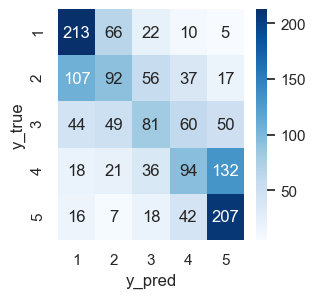

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458,103,217,203,207,83


In [59]:
#params = {'alpha': [1.6, 1.7, 1.8, 1.9, 2, 2.2, 2.5],'norm': [True, False]}
params = {'alpha': [1.8],'norm': [True, False]}

cnb_model = GridSearchCV(ComplementNB(), params)
cnb_model.fit(X_train, y_train)
cnb_model = cnb_model.best_estimator_
print(cnb_model)
y_pred = cnb_model.predict(X_test)
errores5 = error5('Naive Bayes ComplementNB Estrellas', cnb_model, X_train, y_train, X_test, y_test, y_pred, dev_token)
errores5

## 5.2 Random Forest

RandomForestClassifier(max_depth=13, n_estimators=200)


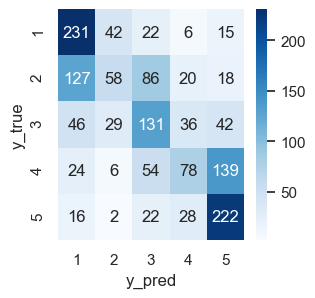

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458,103,217,203,207,83
0,Random Forest Estrellas,0.480,85,251,153,223,68


In [60]:
#params = {'n_estimators': [10, 25, 50, 100, 200],'max_depth': [11,13,15,17]}
params = {'n_estimators': [200],'max_depth': [13]}
rf = GridSearchCV(RandomForestClassifier(), params)
rf.fit(X_train, y_train)
rfo = rf.best_estimator_
print(rfo)
y_pred = rfo.predict(X_test)

errores5 = errores5.append(error5('Random Forest Estrellas', rf, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.3 Ridge Classifier

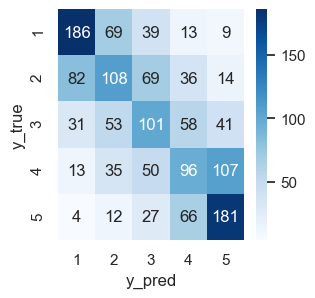

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458,103,217,203,207,83
0,Random Forest Estrellas,0.480,85,251,153,223,68
0,Ridge Estrellas,0.448,130,201,183,205,109


In [61]:
#Generación del modelo lineal
ridge = RidgeClassifier(solver='sag', tol=0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
errores5 = errores5.append(error5('Ridge Estrellas', ridge, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.4 Kneighbors Classifier

KNeighborsClassifier(n_neighbors=16)


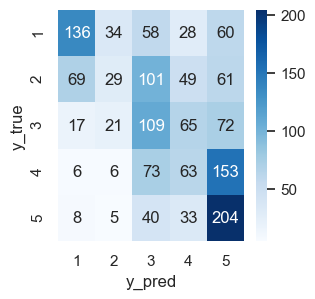

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458000,103,217,203,207,83
0,Random Forest Estrellas,0.480000,85,251,153,223,68
0,Ridge Estrellas,0.448000,130,201,183,205,109
0,KNN Estrellas,0.360667,180,280,175,238,86


In [62]:
params = {'n_neighbors' : [16,17,18,19,20,21]}
neigh = GridSearchCV(KNeighborsClassifier(), params)
neigh.fit(X_train, y_train)
neigho = neigh.best_estimator_
print(neigho)
y_pred = neigho.predict(X_test)
errores5 = errores5.append(error5('KNN Estrellas', neigh, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.5 Nearest Centroid

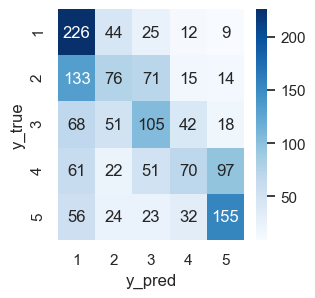

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458000,103,217,203,207,83
0,Random Forest Estrellas,0.480000,85,251,153,223,68
0,Ridge Estrellas,0.448000,130,201,183,205,109
0,KNN Estrellas,0.360667,180,280,175,238,86
0,Nearest Centroid Estrellas,0.421333,90,233,179,231,135


In [63]:
centroid = NearestCentroid()
centroid.fit(X_train, y_train)
y_pred = centroid.predict(X_test)
errores5 = errores5.append(error5('Nearest Centroid Estrellas', centroid, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

## 5.6 Passive Aggressive Classifier

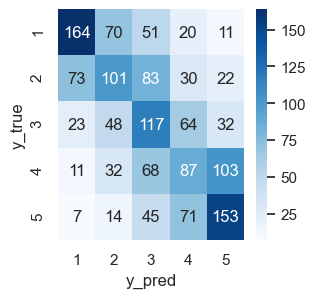

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458000,103,217,203,207,83
0,Random Forest Estrellas,0.480000,85,251,153,223,68
0,Ridge Estrellas,0.448000,130,201,183,205,109
0,KNN Estrellas,0.360667,180,280,175,238,86
0,Nearest Centroid Estrellas,0.421333,90,233,179,231,135
0,Passive Agressive Classifier Estrellas,0.414667,152,208,167,214,137


In [64]:
pac = PassiveAggressiveClassifier()
pac.fit(X_train, y_train)
y_pred = pac.predict(X_test)

errores5 = errores5.append(error5('Passive Agressive Classifier Estrellas', pac, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

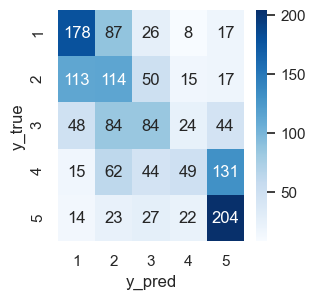

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458000,103,217,203,207,83
0,Random Forest Estrellas,0.480000,85,251,153,223,68
0,Ridge Estrellas,0.448000,130,201,183,205,109
0,KNN Estrellas,0.360667,180,280,175,238,86
0,Nearest Centroid Estrellas,0.421333,90,233,179,231,135
0,Passive Agressive Classifier Estrellas,0.414667,152,208,167,214,137
0,Perceptron Estrellas,0.419333,138,195,200,252,86


In [65]:
params = {'penalty' : ['l2','l1','elasticnet'],
		  'alpha' : [0.0001, 0.001, 0.01, 0.1]}
perceptron = GridSearchCV(Perceptron(), params)
perceptron.fit(X_train, y_train)
perceptron = perceptron.best_estimator_
y_pred = perceptron.predict(X_test)

errores5 = errores5.append(error5('Perceptron Estrellas', perceptron, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

In [ ]:
print(perceptron)

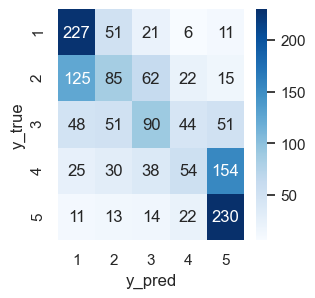

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Naive Bayes ComplementNB Estrellas,0.458000,103,217,203,207,83
0,Random Forest Estrellas,0.480000,85,251,153,223,68
0,Ridge Estrellas,0.448000,130,201,183,205,109
0,KNN Estrellas,0.360667,180,280,175,238,86
0,Nearest Centroid Estrellas,0.421333,90,233,179,231,135
0,Passive Agressive Classifier Estrellas,0.414667,152,208,167,214,137
0,Perceptron Estrellas,0.419333,138,195,200,252,86
0,SGDClassifier Estrellas,0.457333,89,224,194,247,60


In [66]:
#Se demoró 2.1k segundos .
params = {'penalty' : ['l2','l1','elasticnet'],
		  'alpha' : [0.0001, 0.001, 0.01, 0.1]}
sgd = GridSearchCV(SGDClassifier(), params)
sgd.fit(X_train, y_train)
sgd = sgd.best_estimator_
y_pred = sgd.predict(X_test)

errores5 = errores5.append(error5('SGDClassifier Estrellas', sgd, X_train, y_train, X_test, y_test, y_pred, dev_token))
errores5

En general, observamos que la mayor cantidad de errores para todos los modelos es para los comentarios con 2 y 4 estrellas, seguramente debido a que pueden confundirse con comentarios muy malos de 1 estrella o muy buenos de 5 estrellas.

El modelo con mejores resultados es el Random Forest con 0.48 de accuracy, 3 décimas mayor al segundo puesto que es el modelo de Naive Bayes ComplementNB.

# 6. Modelo Final

## 6.1. Preprocesamiento del dataset Train

In [63]:
mini_train = train.sample(20000)
mini_train.reset_index(inplace = True)
mini_train.stars.value_counts()

3    4051
1    4047
5    4010
4    3978
2    3914
Name: stars, dtype: int64

In [64]:
mini_train.review_body, mini_train.review_title = limpieza2(mini_train)

['!' '"' '#' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2' '3'
 '4' '5' '6' '7' '8' '9' ':' ';' '=' '>' '?' '[' '\\' ']' '_' '¡' '°' '¿'
 '×' '\u200b' '\u200d' '‘' '’' '“' '”' '…' '€' '☆' '♀' '♂' '♥' '✨' '️' '🏻'
 '🏼' '🏽' '👀' '👌' '👍' '👎' '💪' '😀' '😁' '😂' '😄' '😉' '😊' '😍' '😒' '😔' '😖' '😞'
 '😟' '😠' '😡' '😣' '😤' '😫' '😳' '🙂' '🙃' '🙄' '🙈' '🤔' '🤦' '🤨' '🤬' '🤷']
Columna review_body
Columna review_title


In [65]:
train_token = tokenizar(mini_train)
train_token.head()

Tokenizado
Columna tokenizada
Columna tokenizada


,review_id,stars,binario,review_body,review_title,body_token,title_token
0,es_0372461,2,0,lo compre para mi hijo de años y la verdad es...,se pega a todo,"[compre, hijo, años, verdad, entretenido, hace...",[pega]
1,es_0086812,1,0,ha cambiado bastante el diseño,el producto final no es igual que en la foto,"[cambiado, bastante, diseño]","[producto, final, no, igual, foto]"
2,es_0732463,2,0,tiene arrugas por lo que cuesta que haga bien ...,mal acabado,"[arrugas, cuesta, haga, bien, precintado]","[mal, acabado]"
3,es_0045865,5,1,correcto mas cara que en otro vendedor,estufa,"[correcto, mas, cara, vendedor]",[estufa]
4,es_0997305,5,1,me ha encantado sobre todo por la funcion de d...,genial,"[encantado, funcion, descongelar, tostar, hace...",[genial]


In [66]:
def lemmatizar(dataset):
    dataset['body_lemma'] = dataset.body_token.apply(lambda x: ' '.join(x))
    dataset['body_lemma'] = dataset.body_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])
    print('Body lematizado')
    dataset['title_lemma'] = dataset.title_token.apply(lambda x: ' '.join(x))
    dataset['title_lemma'] = dataset.title_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])
    print('Title lematizado')

    return dataset

In [67]:
train_token = lemmatizar(train_token)
train_token.head()

Body lematizado
Title lematizado


,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma
0,es_0372461,2,0,lo compre para mi hijo de años y la verdad es...,se pega a todo,"[compre, hijo, años, verdad, entretenido, hace...",[pega],"[comprar, hijo, año, verdad, entretener, hacer...",[pegar]
1,es_0086812,1,0,ha cambiado bastante el diseño,el producto final no es igual que en la foto,"[cambiado, bastante, diseño]","[producto, final, no, igual, foto]","[cambiar, bastante, diseñar]","[producto, final, no, igual, foto]"
2,es_0732463,2,0,tiene arrugas por lo que cuesta que haga bien ...,mal acabado,"[arrugas, cuesta, haga, bien, precintado]","[mal, acabado]","[arrugar, costar, hacer, bien, precintar]","[mal, acabar]"
3,es_0045865,5,1,correcto mas cara que en otro vendedor,estufa,"[correcto, mas, cara, vendedor]",[estufa],"[correcto, mas, caro, vendedor]",[estufar]
4,es_0997305,5,1,me ha encantado sobre todo por la funcion de d...,genial,"[encantado, funcion, descongelar, tostar, hace...",[genial],"[encantar, funcion, descongelar, tostar, hacer...",[genial]


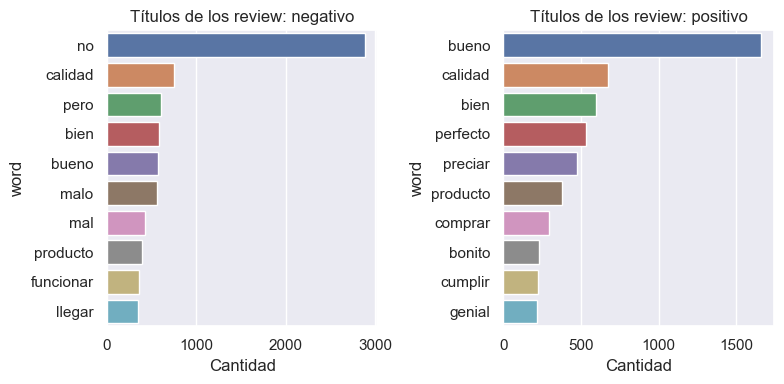

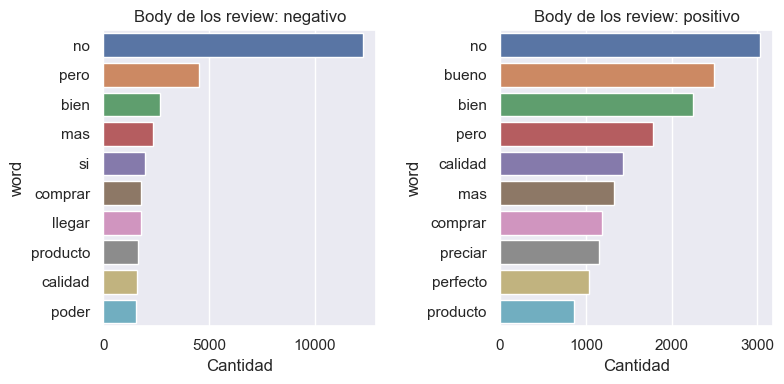

In [68]:
get_freqs(train_token,'title_lemma','Títulos de los review')
get_freqs(train_token,'body_lemma','Body de los review')

In [69]:
train_token['words'] = train_token['title_lemma'] + train_token['body_lemma']
train_token = train_token[['words','stars','binario']]
train_token['words_joint'] = train_token.words.apply(lambda x: ' '.join(x))

In [70]:
train_token['words_no'] = train_token['words_joint'].apply(lambda x: re.sub('^no\s',' no',x))
train_token['words_no'] = train_token['words_no'].apply(lambda x: re.sub('\sno\s',' no',x))
train_token['words_no'] = train_token['words_no'].apply(lambda x: re.sub('^si\s',' si',x))
train_token['words_no'] = train_token['words_no'].apply(lambda x: re.sub('\ssi\s',' si',x))

## 6.2 Preprocesamiento del dataset Test

In [71]:
test.review_body, test.review_title = limpieza2(test)
test_token = tokenizar(test)
test_token.head()

['!' '"' '%' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' ';' '=' '>' '?' '[' ']' '¡' '°' '¿' '\u200d' '’' '“'
 '”' '€' '♂' '️' '😅' '😉' '😊' '😎' '😔' '😕' '😖' '😠' '😡' '🚀' '🚮' '🤦' '🤬']
Columna review_body
Columna review_title
Tokenizado
Columna tokenizada
Columna tokenizada


,review_id,stars,binario,review_body,review_title,body_token,title_token
0,es_0038754,1,0,no me llego el articulo me lo mando por correo...,no me llego,"[no, llego, articulo, mando, correos, normal, ...","[no, llego]"
1,es_0748979,1,0,la mensajeria horrible no compro mas,amazon sigue sin cumplir en las entregas,"[mensajeria, horrible, no, compro, mas]","[amazon, sigue, cumplir, entregas]"
2,es_0411746,1,0,estoy muy decepcionado con el vendedor ya que ...,estafa en el envio,"[decepcionado, vendedor, pedido, no, llego, ti...","[estafa, envio]"
3,es_0786686,1,0,mi valoracion no es sobre el producto sino sob...,estafa de amazon,"[valoracion, no, producto, sino, amazon, ofrec...","[estafa, amazon]"
4,es_0429700,1,0,pues tenia interes en este libro y probe la ve...,no consegui pasar de la portada en kindle,"[pues, tenia, interes, libro, probe, version, ...","[no, consegui, pasar, portada, kindle]"


In [72]:
test_token = lemmatizar(test_token)
test_token.head()

Body lematizado
Title lematizado


,review_id,stars,binario,review_body,review_title,body_token,title_token,body_lemma,title_lemma
0,es_0038754,1,0,no me llego el articulo me lo mando por correo...,no me llego,"[no, llego, articulo, mando, correos, normal, ...","[no, llego]","[no, llegar, articular, mandar, correo, normal...","[no, llegar]"
1,es_0748979,1,0,la mensajeria horrible no compro mas,amazon sigue sin cumplir en las entregas,"[mensajeria, horrible, no, compro, mas]","[amazon, sigue, cumplir, entregas]","[mensajeria, horrible, no, comprar, mas]","[amazon, seguir, cumplir, entregar]"
2,es_0411746,1,0,estoy muy decepcionado con el vendedor ya que ...,estafa en el envio,"[decepcionado, vendedor, pedido, no, llego, ti...","[estafa, envio]","[decepcionar, vendedor, pedir, no, llegar, tie...","[estafar, envio]"
3,es_0786686,1,0,mi valoracion no es sobre el producto sino sob...,estafa de amazon,"[valoracion, no, producto, sino, amazon, ofrec...","[estafa, amazon]","[valoracion, no, producto, sino, amazon, ofrec...","[estafar, amazon]"
4,es_0429700,1,0,pues tenia interes en este libro y probe la ve...,no consegui pasar de la portada en kindle,"[pues, tenia, interes, libro, probe, version, ...","[no, consegui, pasar, portada, kindle]","[pues, tenia, interes, librar, probe, version,...","[no, consegui, pasar, portar, kindle]"


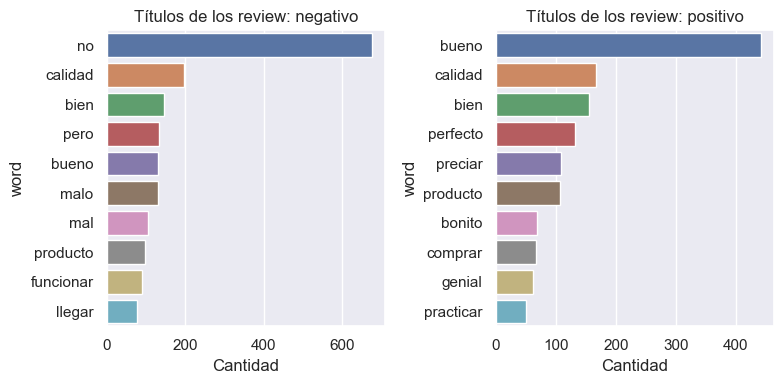

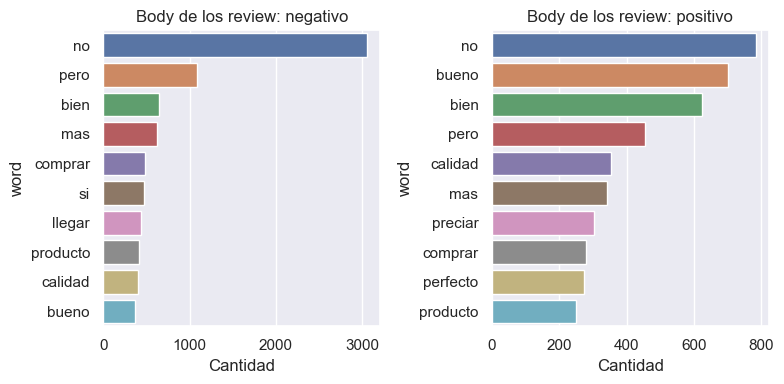

In [73]:
get_freqs(test_token,'title_lemma','Títulos de los review')
get_freqs(test_token,'body_lemma','Body de los review')

In [74]:
test_token['words'] = test_token['title_lemma'] + test_token['body_lemma']
test_token = test_token[['words','stars','binario']]
test_token['words_joint'] = test_token.words.apply(lambda x: ' '.join(x))

In [75]:
test_token['words_no'] = test_token['words_joint'].apply(lambda x: re.sub('^no\s',' no',x))
test_token['words_no'] = test_token['words_no'].apply(lambda x: re.sub('\sno\s',' no',x))
test_token['words_no'] = test_token['words_no'].apply(lambda x: re.sub('^si\s',' si',x))
test_token['words_no'] = test_token['words_no'].apply(lambda x: re.sub('\ssi\s',' si',x))

** Datasets finales**:

In [76]:
train_token

,words,stars,binario,words_joint,words_no
0,"[pegar, comprar, hijo, año, verdad, entretener...",2,0,pegar comprar hijo año verdad entretener hacer...,pegar comprar hijo año verdad entretener hacer...
1,"[producto, final, no, igual, foto, cambiar, ba...",1,0,producto final no igual foto cambiar bastante ...,producto final noigual foto cambiar bastante d...
2,"[mal, acabar, arrugar, costar, hacer, bien, pr...",2,0,mal acabar arrugar costar hacer bien precintar,mal acabar arrugar costar hacer bien precintar
3,"[estufar, correcto, mas, caro, vendedor]",5,1,estufar correcto mas caro vendedor,estufar correcto mas caro vendedor
4,"[genial, encantar, funcion, descongelar, tosta...",5,1,genial encantar funcion descongelar tostar hac...,genial encantar funcion descongelar tostar hac...
...,...,...,...,...,...
19995,"[mandar, distanciar, no, funcionar, mandar, di...",3,0,mandar distanciar no funcionar mandar distanci...,mandar distanciar nofuncionar mandar distancia...
19996,"[retrasar, entregar, producto, aun, no, llegar...",1,0,retrasar entregar producto aun no llegar vende...,retrasar entregar producto aun nollegar vended...
19997,"[protector, parecer, bueno, pero, todavia, no,...",3,0,protector parecer bueno pero todavia no utiliz...,protector parecer bueno pero todavia noutiliza...
19998,"[cumplir, funcion, perfecto, igual, lento]",3,0,cumplir funcion perfecto igual lento,cumplir funcion perfecto igual lento


In [77]:
test_token

,words,stars,binario,words_joint,words_no
0,"[no, llegar, no, llegar, articular, mandar, co...",1,0,no llegar no llegar articular mandar correo no...,nollegar nollegar articular mandar correo nor...
1,"[amazon, seguir, cumplir, entregar, mensajeria...",1,0,amazon seguir cumplir entregar mensajeria horr...,amazon seguir cumplir entregar mensajeria horr...
2,"[estafar, envio, decepcionar, vendedor, pedir,...",1,0,estafar envio decepcionar vendedor pedir no ll...,estafar envio decepcionar vendedor pedir nolle...
3,"[estafar, amazon, valoracion, no, producto, si...",1,0,estafar amazon valoracion no producto sino ama...,estafar amazon valoracion noproducto sino amaz...
4,"[no, consegui, pasar, portar, kindle, pues, te...",1,0,no consegui pasar portar kindle pues tenia int...,noconsegui pasar portar kindle pues tenia int...
...,...,...,...,...,...
4995,"[perfecto, servir, costar, perfecto, cumplir, ...",5,1,perfecto servir costar perfecto cumplir funcio...,perfecto servir costar perfecto cumplir funcio...
4996,"[bueno, vendedor, rapido, fiable, material, fl...",5,1,bueno vendedor rapido fiable material flexible...,bueno vendedor rapido fiable material flexible...
4997,"[medalla, bonito, grabar, ver, bien, grabar]",5,1,medalla bonito grabar ver bien grabar,medalla bonito grabar ver bien grabar
4998,"[timbrar, comprar, bici, pero, finalmente, que...",5,1,timbrar comprar bici pero finalmente quedar xi...,timbrar comprar bici pero finalmente quedar xi...


In [78]:
data = pd.concat([train_token.words_no, test_token.words_no])

In [79]:
# Series de resultados y
ybin = mini_train.binario
ystars = mini_train.stars
ybin_test = test_token.binario
ystars_test = test_token.stars

## 6.3 Modelo de Machine Learning Binario

In [80]:
vectorizador = CountVectorizer(lowercase = False)
vec = vectorizador.fit_transform(data)
whole_thing = vec.toarray()
X_train_data = whole_thing[:20000]
X_test_data = whole_thing[-5000:]

LogisticRegression(C=1, penalty='l1', solver='liblinear', tol=0.09)


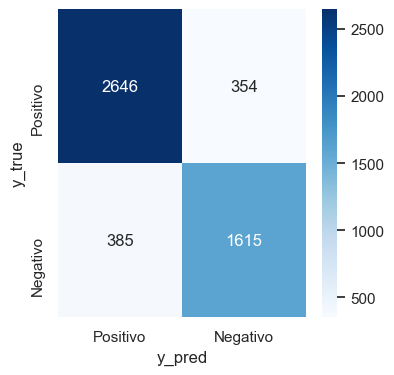

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Validación binaria: Regresión Logística,0.8522,0.813807,1615,2646,354,385


In [81]:
#params = {'penalty': ['l1', '‘l2', 'elasticnet', 'none'],'tol': [0-07,0.08,0.09,0.1,0.11]}
params = {'penalty': ['l1'],'tol': [0.09]}
lr_model = GridSearchCV(LogisticRegression(C=1, solver="liblinear"), params)
lr_model.fit(X_train_data, ybin)
print(lr_model.best_estimator_)
best_lr = lr_model.best_estimator_
y_pred = lr_model.best_estimator_.predict(X_test_data)
errores_val = error('Validación binaria: Regresión Logística', best_lr, X_train_data, ybin, X_test_data, ybin_test, y_pred)
errores_val

### 6.4 Modelo de Clasificación de estrellas

RandomForestClassifier(max_depth=12, n_estimators=200)


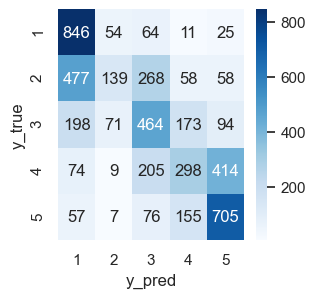

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Random Forest Estrellas Validation,0.4904,154,861,536,702,295


In [82]:
params = {'n_estimators': [200], 'max_depth': [12]}
rf = GridSearchCV(RandomForestClassifier(), params)
rf.fit(X_train_data, ystars)
rfo = rf.best_estimator_
print(rfo)
y_pred = rfo.predict(X_test_data)
errores_val = error5('Random Forest Estrellas Validation', rfo, X_train_data, ystars, X_test_data, ystars_test, y_pred, test_token)
errores_val

# 7. Parte C: Análisis de Emojies

En los procesos de limpieza vimos que se extrayeron emojis, queremos saber si dejarlos en el corpus implicaría una mejora en nuestros dos mejores modelos. Para esto usaremos la librería emot para convertirlos a palabras identificadoras que posteriormente vectorizaremos y dejaremos en el dataset para ser tenidas en cuenta en el modelo. 

Para esto usaremos solo el dataset de dev ya que como vimos anteriormente el dataset de train es muy grande para la memoría de la mayoría de computadores domésticos y esto es un ejercicio con fines ilustrativos del valor informativo de los emojies.

Es posible obtener con la libreria previamente menciona el significado y ubicación en el string de cada emoj, como se muestra a continuación

In [83]:
import emot
emot_obj = emot.core.emot()
emot_obj.emoji("❤ 😂 😊 😡")

{'value': ['❤', '😂', '😊', '😡'],
 'location': [[0, 1], [2, 3], [4, 5], [6, 7]],
 'mean': [':red_heart:',
  ':face_with_tears_of_joy:',
  ':smiling_face_with_smiling_eyes:',
  ':pouting_face:'],
 'flag': True}

Usaremos esto para reemplazar los emojis con el significado que tienen

In [84]:
def replace_emojis(df, column):

	df[column] = df[column].apply(lambda x: re.sub(r"[^a-z]", r" \g<0>", x))

	for i in range(len(df[column])):

		row_emojis = emot_obj.emoji(df[column][i])['value']
		row_meanings = emot_obj.emoji(df[column][i])['mean']
		
		if len(row_emojis) == 0: 
			continue
		else:
			emoji_and_mean = {}
			for j in range(len(row_emojis)):
				emoji_and_mean[row_emojis[j]]= row_meanings[j]
			df[column][i] = " ".join(emoji_and_mean.get(ele, ele) for ele in df[column][i].split())

	df[column] = df[column].apply(lambda x: re.sub('_', '', x))

	return df

Usaremos el dataset de development para testear la hipótesis de que mantener los emojis en el dataset mejorará el performance del modelo

In [85]:
#leemos de nuevo el datset
dev = pd.read_json('dataset_es_dev.json', lines = True)
# pasamos todo a minúscula
dev.review_body = dev.review_body.apply(lambda x: x.lower())
dev.review_title = dev.review_title.apply(lambda x: x.lower())
#quitamos las tildes
dev.review_body = dev.review_body.apply(lambda x: tildes(x))
dev.review_title = dev.review_title.apply(lambda x: tildes(x))
# creamos la columna de calificación binaria
dev['binario'] = np.where(dev.stars > 3, 1, 0)

In [86]:
#finalmente, reemplazamos los emojis
dev = replace_emojis(dev, 'review_title')
dev = replace_emojis(dev, 'review_body')

Y ahora podemos repetir nuestro preprocesamiento común para generar el dataset con el mejor performance, pero esta vez con emojis.

In [87]:
dev.review_body, dev.review_title = limpieza2(dev)
dev_token_emoji = tokenizar(dev)

['!' '"' '#' '%' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2' '3' '4'
 '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '~' '¡' '°' '¿' '”' '…' '€'
 '️']
Columna review_body
Columna review_title
Tokenizado
Columna tokenizada
Columna tokenizada


Confirmado que ya no hay emojis en el texto, pasamos a lemmatizar

In [88]:
dev_token_emoji['body_lemma'] = dev_token_emoji.body_token.apply(lambda x: ' '.join(x))
dev_token_emoji['body_lemma'] = dev_token_emoji.body_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])
dev_token_emoji['title_lemma'] = dev_token_emoji.title_token.apply(lambda x: ' '.join(x))
dev_token_emoji['title_lemma'] = dev_token_emoji.title_lemma.apply(lambda y: [token.lemma_ for token in nlp(y)])

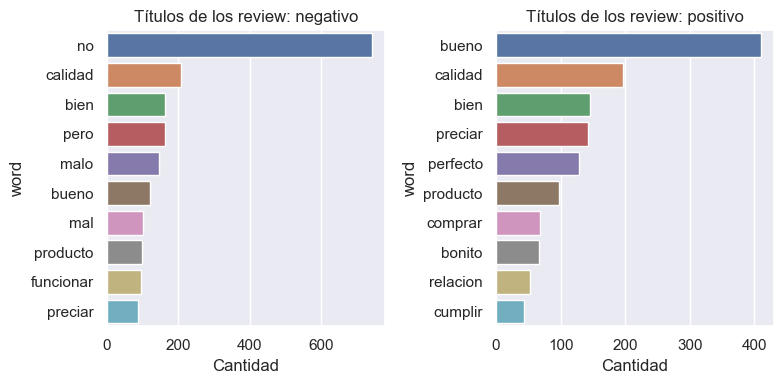

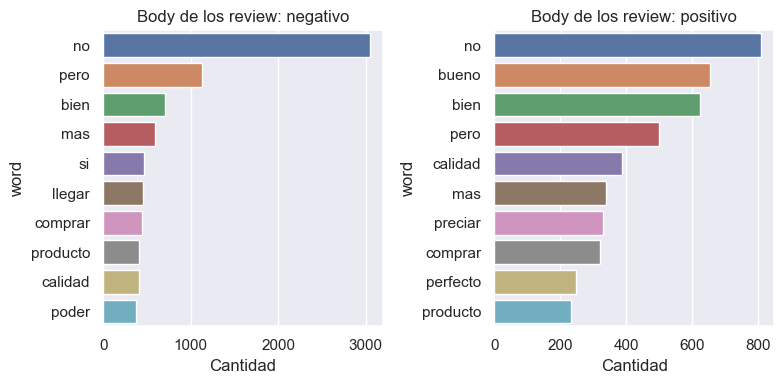

In [89]:
get_freqs(dev_token_emoji,'title_lemma','Títulos de los review')
get_freqs(dev_token_emoji,'body_lemma','Body de los review')

Ahora, correremos los mejores modelos para ambos casos

In [90]:
#Unimos las palabras en una columna, y las unimos en un solo string
dev_token_emoji['words'] = dev_token_emoji['title_lemma'] + dev_token_emoji['body_lemma']
data_emoji = dev_token_emoji[['words','stars','binario']]
data_emoji['words_joint'] = data_emoji.words.apply(lambda x: ' '.join(x))

# generamos los bigramas con si y no
data_emoji['words_no'] = data_emoji['words_joint'].apply(lambda x: re.sub('^no\\s',' no',x))
data_emoji['words_no'] = data_emoji['words_no'].apply(lambda x: re.sub('\\sno\\s',' no',x))
data_emoji['words_no'] = data_emoji['words_no'].apply(lambda x: re.sub('^si\\s',' si',x))
data_emoji['words_no'] = data_emoji['words_no'].apply(lambda x: re.sub('\\ssi\\s',' si',x))

In [91]:
vectorizador=CountVectorizer(lowercase = False)
data_emoji_vec = vectorizador.fit_transform(data_emoji.words_no)
X_emoji = data_emoji_vec.toarray()
ybin_emoji = data_emoji['binario']
ystars_emoji = data_emoji['stars']

## 7.1 Modelo Binario

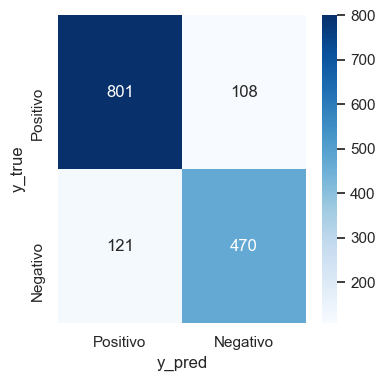

,Modelo,Accuracy,f1_score,VP,VN,FP,FN
0,Regresión Logística Emoji,0.847333,0.804106,470,801,108,121


In [92]:
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X_emoji, ybin_emoji, test_size = 0.3, random_state=42)

lr_model = LogisticRegression(C=1, solver="liblinear", penalty='l1', tol=0.09)
lr_model.fit(X_train, y_train_bin)
y_pred = lr_model.predict(X_test)
errores = error('Regresión Logística Emoji', lr_model, X_train, y_train_bin, X_test, y_test_bin, y_pred)
errores

## 7.2 Modelo 5 Estrellas

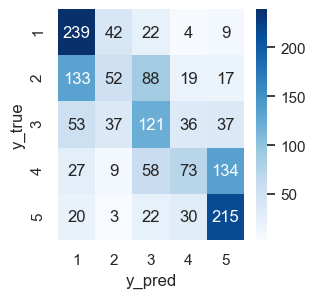

,Modelo,Accuracy,Errores 1,Errores 2,Errores 3,Errores 4,Errores 5
0,Random Forest Estrellas Validation,0.466667,77,257,163,228,75


In [95]:
X_train, X_test, y_train_stars, y_test_stars = train_test_split(X_emoji, ystars_emoji, test_size = 0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=13)
rf.fit(X_train, y_train_stars)
y_pred = rf.predict(X_test)
#y_test_stars.reset_index(drop = True, inplace = True)
errores_val = error5('Random Forest Estrellas Validation', rf, X_train, y_train_stars, X_test, y_test_stars, y_pred, dev_token_emoji)
errores_val


Como podemos ver, nuestro modelo no presenta mejoras significativas con la inclusión de los emojies. Sin embargo diremos que es un ejercicio simple que debe ser un paso obligatorio en cualquier otro ejercicio de clasificación de texto online. Nuestra comunicación actual depende en gran medida de los emojies, y si no en este caso, seguramente en cosas como tweets o conversaciones por chat los emojies tendrán bastante valor en indicar el tono del mensaje.

# 8. Conclusiones

Desde que leímos el reto supimos que el problema principal iba a ser capturar aspectos del lenguaje humano que no son consecuentes. El hecho de que cada persona puede escribir la misma palabra de maneras diferentes, usarla de manera errónea en oraciones, usarla sarcásticamente, equivocarse al seleccionar el valor del review que realmente quería, entre otros es una fuente de ruido muy alta.
 
Nuestros problemas principales en las clasificaciones fueron consistentemente las 2 y 4 estrellas, en las que las personas describen cuán malo o bueno el producto es respectivamente pero después no le dan la peor o mejor calificación por algún motivo. Programar un algoritmo que capture ese tipo de comportamiento intrínsecamente humano es un reto bastante grande.
 
Para definir **qué información usar en el modelo de predicción**, desarrollamos varios modelos binarios en *dev*, para ello utilizamos distintas variaciones de nuestro dataset de desarrollo: 
 
Dataset tokenizado: Inicialmente pasamos todos los carácteres de los comentarios a minúscula para evitar diferencias entre las palabras que va a utilizar para la predicción, luego, tokenizamos mediante la libreria nltk y eliminamos las stopwords. Después de iteraciones posteriores decidimos mantener las palabras “no” y “pero” ya que generaban mejores resultados. Lemmatizamos mediante la librería de Spacy, la cual presentó mejores resultados en comparación con la lemmatización de otras librerías. Sin embargo, viendo algunos ejemplos, nos dimos cuenta que presenta varios errores en cuanto a la clasificación de las palabras, especialmente con muchos verbos que categorizaba como adjetivos o adverbios. Aún así, la lemmatización en términos generales es buena al tomar únicamente las raiz de las palabras y unificando verbos que estan conjugados en una sola palabra. 
 
Dataset sin palabras frecuentes: Con base en el resultado de frecuencia de palabras en el dataset, observamos que muchas palabras se repetian tanto para los comentarios buenos como malos tal como “producto” o “calidad”, lo cual pensamos podría generar predicciones erróneas a la hota de ejecutar el modelo. Por esto, realizamos una nueva prueba con el dataset tokenizado, eliminando el 1% de las palabras más frecuentes de todo el dataset y el 1% de las menos frecuentes que pueden ser palabras de ruido y así reduciendo el espacio vectorial del modelo. Esto resultó en palabras más representativas para los comentarios en el análisis de frecuencia, pero no mejoró el performance del modelo. Fue necesario revisar las palabras eliminadas, ya que algunas eran bastante importantes como “malo”, “perfecto” y “bonito”. Así, que estas las mantenemos en el dataset.
 
Dataset en bigramas: Como siguiente prueba tokenizamos el dataset inicial en bigramas, para probar como resultaba el modelo trabajando con tokens dobles. Mantuvimos las palabras frecuentes en este caso.
 
Dataset tokenizado con bigramas solo para los términos que incluían *si* y *no*: Finalmente, observamos que por ejemplo reviews que decian: *no hay problema*, resultaban en los tokens: *no* y *problema*, que son en general palabras que definen un review negativo y en este caso es positivo. Por lo cual decidimos unir las palabras *no* con la siguiente palabra, fuese verbo o sustantivo. De forma que se diferencian tokens como *problema* y *noproblema* y generaramos tokens como *nofuncionar*, *noservir* o *nollegar*, que claramente identificaban los reviews como negativos. De la misma forma lo aplicamos a la palabra “si”. 
 
La definición de los datasets anteriores fueron un proceso iterativo que consistió en probar diferentes combinaciones, palabras eliminadas, cantidad de tokens y principalmente en estudiar los reviews que los modelos predecían erróneamente para modificar el preprocesamiento y mejorar los resultados. Partimos de resultados con modelos y datasets muy básicos de alrededor del 60% de accuracy y gracias a la iteración y optimización logramos llegar a un accuracy de hasta 84%. 
 
Así que de acuerdo con los resultados de todos los modelos optimizados para cada uno de los datasets anteriores y a partir de los valores de accuracy, concluimos que: 
 
El dataset tokenizado presentó mejores resultados que el dataset con las palabras más frecuentes eliminadas, así que nuestra hipótesis de que las palabras repetidas en comentarios afirmativos y negativos empeoraban el modelo fue refutada. El dataset de bigramas presentó los peores resultados, de entre 65% y 78% de accuracy. El peor entre ellos es el modelo de random forest el cual predijo 1408 reviews como negativos en comparación a 92 reviews como positivos, de forma que obtuvo un f1_score tan bajo como 0.23. Así que decidimos continuar con tokenizado de monogramas. 
 
El modelo que mejor resultado generó fue la regresión logística con los bigramas afirmativos y negativos con un accuracy del 84% y un f1_score de 0.8, también el más alto de todos los modelos. De forma, que es un modelo adecuado tanto para reviews positivos como negativos. El preprocesamiento de este último dataset es el seleccionado para preparar los datos y la información de entrada de los modelos finales.
 
Ya con el pre-procesamiento de datos definido gracias a los modelos binarios, procedemos a probar diferentes modelos optimizados para la clasificación de las 5 estrellas, de forma que determinamos el mejor modelo para aplicar a los dataset train y test. Nuevamente, fue un proceso iterativo junto con la sección anterior, donde logramos aumentar el accuracy de valores tan bajos como 19% a valores de aproximadamente 45
%. Este último en el modelo de Random Forest, el cual fue seleccionado como modelo final.
 
Al aplicar nuestro mejor pre-procesamiento y los mejores modelos tanto para binario como para clasificación en los datasets Train con 20.000 datos y Test con 5.000 datos, obtuvimos mejores resultados de accuracy: 85% para binario y 50% para clasificación. Lo anterior nos demuestra como la cantidad de datos e información de entrenamiento es fundamental para desarrollar modelos más precisos.
 
También nos preguntamos si **vale la pena convertir el modelo a uno binario**, vimos que los modelos se ajustan mucho mejor a un problema binario,obtuvimos nuestro máximo accuracy en este tipo de modelos con un 84% de la regresión logística que usa la función sigmoide justo para predecir 0 o 1. Para expresar el sentimiento de los usuarios hacia un producto decir positivo o negativo sería valioso por sí solo, en este caso esa información se podría usar como una señal visual en cada comentario de la página web. Pero el sistema de 5 estrellas, aunque más complejo y por eso más vulnerable a fluctuaciones humanas de estado anímico y subjetividades, permite darle matices a esa afirmación de bueno o malo, y esto se convierte en información decisiva para los compradores en el momento de elegir entre dos fabricantes de un mismo producto, o dos vendedores de la misma referencia. Para cuestiones de este ejercicio si fue valioso convertir el problema a binario, y cruzando esta simple información con información de los productos y de las personas que dejaron los reviews seguro lograría mostrar tendencias interesantes